### Here you can find the necessary import

In [1]:
import tensorflow as tf 
import os 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# you need the current working directory NB: works both windows and linux 
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

if not os.path.exists(f"{current_working_directory}/Datasets"):
    os.makedirs(f"{current_working_directory}/Datasets")

print(f"[DATASET] PUT THE DATASET here: {current_working_directory}/Datasets")


[DATASET] PUT THE DATASET here: C:\Users\Pikkis/Datasets


In [3]:
# get the directory where I want to download the dataset
path_of_dataset = os.path.join(*['..', current_working_directory, 'Datasets', 'pizza_not_pizza'])
print(f"[DIR] The directory of the current dataset is {path_of_dataset}")

[DIR] The directory of the current dataset is C:\Users\Pikkis\Datasets\pizza_not_pizza


### Data prep

In [4]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    """
    This function help you to load the data dynamically 
    :param data_set_path: (str) put the path created in the previous cell (is the dataset path) 
    :param target_size: (tuple) the desired size of the images  
    :return: 
        - array of images 
        - array with labels 
        - list of labels name (this is used for better visualization)
    """
    try:
        dataset, labels, name_of_the_labels = list(), list(), list() 
        # let s loop here and we try to discover how many class we have 
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(*[data_set_path, class_name])
            print(f"[WALK] I am walking into {full_path_the_data}")
            
            # add the list to nam _list
            name_of_the_labels.append(class_name)
            
            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])
                
                # add the class number 
                labels.append(class_number)
                
                if target_size is None:
                    # let s load the image 
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)
                
                # transform PIL object in image                    
                image = tf.keras.utils.img_to_array(image)
                
                # add the image to the ds list 
                dataset.append(image)
                
        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

#### Load the data 

In [5]:
# load the data 
data = load_the_data_and_the_labels(path_of_dataset, (224,224,3))

[WALK] I am walking into C:\Users\Pikkis\Datasets\pizza_not_pizza\not_pizza
[WALK] I am walking into C:\Users\Pikkis\Datasets\pizza_not_pizza\pizza


#### Normalize the data 

In [6]:
# normalize the data 
mean = np.mean(data[0])
std = np.std(data[0])
n_data = [(d-mean)/std for d in data[0]]

data_arr = np.asarray(n_data)

#### Split the data use the train_test_split function 

In [7]:
# split the data in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(data_arr, data[1], test_size=0.3, random_state=1)

### Create the CNN according the instruction:
        a. Input layer
        b. Data augmentation, with random flip (horizontal and vertical) and random rotation (0.2).
        c. Two hidden layers each composed with the following characteristics: 16 conv2d units, max pooling 2d and batch normalization, the second one should have 24 conv2d units max pooling 2d and batch normalization. 
        d. After this, add a flatten layer and a dense layer with 8 units
        e. Add the final classifier (a  dense layer) with the correct number of output and activation
        
![alt text](assignment_1_two_layers_CNN.png "CNN with two layers")

In [8]:
# create the cnn

#Creating the input layer
input_layer = tf.keras.Input(shape=(224,224,3))

# Augment layer with random flip and rotation
augment_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical"),tf.keras.layers.RandomRotation(0.2)])(input_layer)

# Two hidden layers with Conv2D, MaxPooling2D and batch normalization
hidden_layer1 = tf.keras.layers.Conv2D(16, (3,3),activation='relu', input_shape=(224,224,3))(augment_layer)
max_pooling2d = tf.keras.layers.MaxPooling2D(2,2)(hidden_layer1)
batch_normalize = tf.keras.layers.BatchNormalization(axis=-1)(max_pooling2d)
hidden_layer2 = tf.keras.layers.Conv2D(24, (3,3), activation='relu', input_shape=(224,224,3))(batch_normalize)
max_pooling2d2 = tf.keras.layers.MaxPooling2D(2,2)(hidden_layer2)
batch_normalize2 = tf.keras.layers.BatchNormalization(axis=-1)(max_pooling2d2)

# Flatten layer
flatten_layer = tf.keras.layers.Flatten()(batch_normalize2)

# Our final two dense layers
dense_layer = tf.keras.layers.Dense(units=8, activation='relu')(flatten_layer)
final_dense_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(dense_layer)

# Finishing our model
model = tf.keras.Model(input_layer, final_dense_layer)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 24)      3480

### compile the model 
Compile the model with Adam optimizer and binary cross entropy as loss function. 

In [9]:
# compile the CNN 

# Compiling our cnn
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

### Train the model with 128 epochs and 64 batch size 

In [10]:
# Training our model with 128 epochs and batch size 64
model.fit(X_train, y_train, epochs=128, batch_size=64)

Epoch 1/128


22/22 [==============================] - 6s 205ms/step - loss: 1.5158 - accuracy: 0.6206
Epoch 2/128
22/22 [==============================] - 5s 207ms/step - loss: 1.2996 - accuracy: 0.5778
Epoch 3/128
22/22 [==============================] - 5s 206ms/step - loss: 0.9886 - accuracy: 0.6235
Epoch 4/128
22/22 [==============================] - 5s 207ms/step - loss: 0.9598 - accuracy: 0.6795
Epoch 5/128
22/22 [==============================] - 5s 206ms/step - loss: 0.8972 - accuracy: 0.7020
Epoch 6/128
22/22 [==============================] - 5s 208ms/step - loss: 0.8130 - accuracy: 0.6962
Epoch 7/128
22/22 [==============================] - 5s 207ms/step - loss: 0.6393 - accuracy: 0.7311
Epoch 8/128
22/22 [==============================] - 4s 204ms/step - loss: 0.5812 - accuracy: 0.7456
Epoch 9/128
22/22 [==============================] - 4s 197ms/step - loss: 0.5343 - accuracy: 0.7558
Epoch 10/128
22/22 [==============================] - 4s 199ms/step - loss: 0.4969 - accu

### Evaluate the model and report the accuracy 

In [11]:
#Evaluating our model and reporting the accuracy
scores = model.evaluate(X_test, y_test)

19/19 [==============================] - 1s 26ms/step - loss: 0.6329 - accuracy: 0.8051


### Make prediction with the test set and use a threshold of 0.5 as boundaries decision between the classes. 

In [12]:
# do it here 

#Making some predictions
predictions = model.predict(X_test)

#Setting a 0.5 threshold
threshold_predictions = (predictions > 0.5).astype(int)

#Modifying our array to better fit the prediction function below
test = threshold_predictions.tolist()
real_predictions = []

for xs in test:
    for x in xs:
        real_predictions.append(x)

19/19 [==============================] - 1s 26ms/step


### show predictions

In [13]:
def show_some_prediction(number_of_subplot, test_set, predictions, name_of_the_labels):
    for i in range(number_of_subplot):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(test_set[i])
        plt.title(f'{name_of_the_labels[predictions[i]]}')
        plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


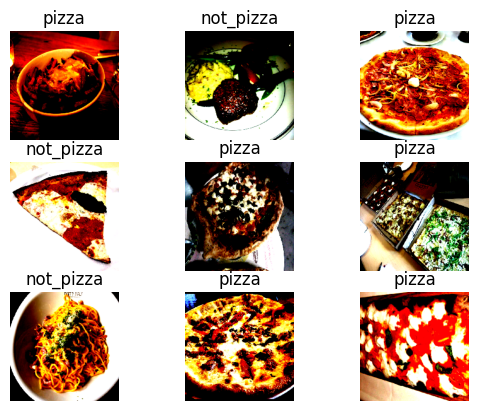

In [14]:
# do it here 

#Using our premade function to display some predicted images
show_some_prediction(9, X_test, real_predictions, data[2])

### show metrics like confusion matrix or ROC curve or both (sklearn has already implemented all these stuff)

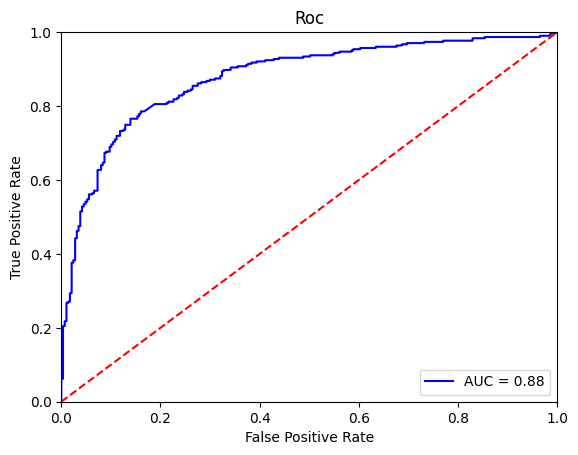

In [15]:
#Calculating our roc
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

#Plotting and displaying our roc curve
plt.title('Roc')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Build another base CNN, but at point c add an extra hidden layer with 32 units of conv2d.  Repeat all the other steps. What happened to the accuracy of the model? Why?  

![alt text](assignment_1_three_layers_CNN.png "CNN with three layers")

In [16]:
#Creating second cnn

#Input layer
xinput_layer = tf.keras.Input(shape=(224,224,3))

#Data augmentation layer with random flip and rotation
xaugment_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical"),tf.keras.layers.RandomRotation(0.2)])(xinput_layer)

#Three hidden layers with Conv2D, MaxPooling2D and Batch normalization
xhidden_layer1 = tf.keras.layers.Conv2D(16, (3,3),activation='relu', input_shape=(224,224,3))(xaugment_layer)
xmax_pooling2d = tf.keras.layers.MaxPooling2D(2,2)(xhidden_layer1)
xbatch_normalize = tf.keras.layers.BatchNormalization(axis=-1)(xmax_pooling2d)

xhidden_layer2 = tf.keras.layers.Conv2D(24, (3,3), activation='relu', input_shape=(224,224,3))(xbatch_normalize)
xmax_pooling2d2 = tf.keras.layers.MaxPooling2D(2,2)(xhidden_layer2)
xbatch_normalize2 = tf.keras.layers.BatchNormalization(axis=-1)(xmax_pooling2d2)

xhidden_layer3 = tf.keras.layers.Conv2D(24, (3,3), activation='relu', input_shape=(224,224,3))(xbatch_normalize2)
xmax_pooling2d3 = tf.keras.layers.MaxPooling2D(2,2)(xhidden_layer3)
xbatch_normalize3 = tf.keras.layers.BatchNormalization(axis=-1)(xmax_pooling2d3)

#Flatten layer
xflatten_layer = tf.keras.layers.Flatten()(xbatch_normalize3)

#Two dense layers
xdense_layer = tf.keras.layers.Dense(units=8, activation='relu')(xflatten_layer)
xfinal_dense_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(xdense_layer)

#Final model
model2 = tf.keras.Model(xinput_layer, xfinal_dense_layer)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 111, 111, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 24)      3480

In [17]:
#Compiling our model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [18]:
#Training our model with batch size 64 and 128 epochs.
model2.fit(X_train, y_train, epochs=128, batch_size=64)

Epoch 1/128
22/22 [==============================] - 6s 221ms/step - loss: 0.7058 - accuracy: 0.6788
Epoch 2/128
22/22 [==============================] - 5s 219ms/step - loss: 0.5981 - accuracy: 0.7173
Epoch 3/128
22/22 [==============================] - 5s 220ms/step - loss: 0.6198 - accuracy: 0.7442
Epoch 4/128
22/22 [==============================] - 5s 220ms/step - loss: 0.5413 - accuracy: 0.7435
Epoch 5/128
22/22 [==============================] - 5s 220ms/step - loss: 0.5265 - accuracy: 0.7645
Epoch 6/128
22/22 [==============================] - 5s 220ms/step - loss: 0.5294 - accuracy: 0.7660
Epoch 7/128
22/22 [==============================] - 5s 219ms/step - loss: 0.5015 - accuracy: 0.7624
Epoch 8/128
22/22 [==============================] - 5s 220ms/step - loss: 0.4691 - accuracy: 0.7856
Epoch 9/128
22/22 [==============================] - 5s 219ms/step - loss: 0.4419 - accuracy: 0.7922
Epoch 10/128
22/22 [==============================] - 5s 219ms/step - loss: 0.4585 - accura

In [19]:
#Evaluating our second model and reporting the accuracy
scores2 = model2.evaluate(X_test, y_test)

19/19 [==============================] - 1s 28ms/step - loss: 0.5912 - accuracy: 0.8169


In [20]:
# do it here 

#Making some predictions
predictions2 = model2.predict(X_test)

#Setting a 0.5 threshold
threshold_predictions2 = (predictions2 > 0.5).astype(int)

#Modifying our array to better fit the prediction function below
test2 = threshold_predictions2.tolist()
real_predictions2 = []

for xs in test2:
    for x in xs:
        real_predictions2.append(x)

19/19 [==============================] - 1s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


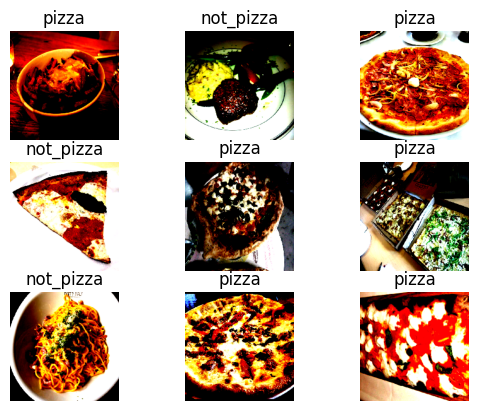

In [21]:
# do it here 

#Using our premade function to display some predicted images
show_some_prediction(9, X_test, real_predictions, data[2])

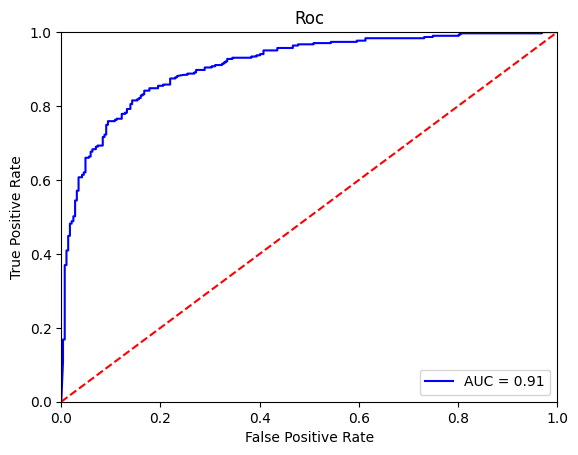

In [22]:
#Calculating our roc
fpr, tpr, threshold = roc_curve(y_test, predictions2)
roc_auc = auc(fpr, tpr)

#Plotting and displaying our roc curve
plt.title('Roc')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<p> According do the epochs, our model seemed more accurate but after checking the score, it was about the same as our first model. I'd trust the epochs more as more convolutions should produce a better estimate of our images. </p>